In [2]:
import json
import munch

import tensorflow as tf
import numpy as np
import sde as eqn
import options as opts
from markov_solver import BSDEMarkovianModel
from options import LookbackOption, GeometricAsian
from function_space import DeepONet, DeepONetwithPI

import matplotlib.pyplot as plt
from utils import mc_price
import os
os.getcwd()
sde_list = ["GBM", "SV", "CEV", "SVJ"]
option_list = ["European", "Lookback", "Asian", "Basket"]
dim_list = [1, 5, 10, 20]

In [3]:
def get_useful_series(sde_name: str, option_name: str, dim: int=1, seed: int=0):
    tf.random.set_seed(seed)
    np.random.seed(seed)
   
    if (sde_name not in sde_list) or (option_name not in option_list) or (dim not in dim_list):
        raise ValueError(f"please input right sde_name in {sde_list},\
                          option_name in {option_list} and dim in {dim_list}")
    else:
        json_path = f'config/{sde_name}_{option_name}_{dim}.json'
    with open(json_path) as json_data_file:
        config = json.load(json_data_file)
    
    config = munch.munchify(config)
    sde = getattr(eqn, config.eqn_config.sde_name)(config)
    option = getattr(opts, config.eqn_config.option_name)(config)
    print(option)
    solver = BSDEMarkovianModel(sde, option, config)
    solver.pre_setting()
    model = solver.model
    mode = config.eqn_config.initial_mode
     
    u_model = sde.sample_parameters(N=1, training=False)
    u_option = option.sample_parameters(N=1, training=False)
    u_hat = tf.concat([u_model, u_option], axis=-1)
    x, _ = sde.sde_simulation(u_hat, config.val_config.sample_size)
    time_stamp = tf.range(0, config.eqn_config.T, config.eqn_config.dt)
    time_steps = config.eqn_config.time_steps
    time_stamp = tf.reshape(time_stamp, [1, 1, time_steps, 1])
    t = tf.tile(time_stamp, [u_hat.shape[0], config.eqn_config.sample_size, 1, 1])
    u_hat = sde.expand_batch_inputs_dim(u_hat)
    # model.load_weights(f"checkpoint/{sde_name}_{option_name}_{dim}")
    print(config.net_config.kernel_type)


    model.no_net.load_weights(f"checkpoint/{sde_name}_{option_name}_{dim}_{mode}_conv")
    if type(option) == LookbackOption or type(option) == GeometricAsian:
        x_m = option.markovian_var(x)
        x_arg = tf.concat([x, x_m], axis=-1)
    else: 
        x_arg = x
    y_pred = model.net_forward((t, x_arg, u_hat))
    y_pred = tf.squeeze(y_pred).numpy()
    t_test = tf.squeeze(t).numpy()
    x_mc = tf.squeeze(x_arg[:,:,:,:dim]).numpy()
    u = tf.squeeze(u_hat[:, 0,0, :]).numpy()

    mc_p = mc_price(x_arg[:,:,:,:dim], u_hat[:, 0,0, :])

    if sde_name == "GBM" and option_name == "European" and dim == 1:
        y_true = option.exact_price(t, x, u_hat)
        y_true = tf.squeeze(y_true).numpy()
    
        return y_pred, x_mc, t_test, u, y_true
    
    elif sde_name == "GBM" and option_name == "Lookback" and dim == 1:
        y_true = option.exact_price(t, x_arg, u_hat)
        y_true = tf.squeeze(y_true).numpy()
        return y_pred, x_mc, t_test, u, y_true
    
    elif sde_name == "GBM" and option_name == "Asian" and dim == 1:
        y_true = option.exact_price(t, x_arg, u_hat)
        y_true = tf.squeeze(y_true).numpy()
        return y_pred, x_mc, t_test, u, y_true
    
    
    elif sde_name == "GBM" and option_name == "Basket_wo_PI" and dim != 1:
        y_true = option.exact_price(t, x_arg, u_hat)
        y_true = tf.squeeze(y_true).numpy()
        x_mc = tf.reduce_mean(x_arg, axis=-1)
        x_mc = tf.squeeze(x_mc).numpy()
        return y_pred, x_mc, t_test, u, y_true
    
    elif sde_name == "GBM" and option_name == "Basket" and dim != 1:
        y_true = option.exact_price(t, x_arg, u_hat)
        y_true = tf.squeeze(y_true).numpy()
        x_mc = tf.reduce_mean(x_arg, axis=-1)
        x_mc = tf.squeeze(x_mc).numpy()
        return y_pred, x_mc, t_test, u, y_true
    
    else:
        return y_pred, x_mc, t_test, u, mc_p.numpy()



data = get_useful_series("GBM", "Basket", 10, 0)     
# print(data[1][0, :, 0]) 
print(data[0].shape, data[-1].shape)

EuropeanBasketOption()
conv
(50, 50, 100, 10)
(50, 50, 100) (50, 50, 100)


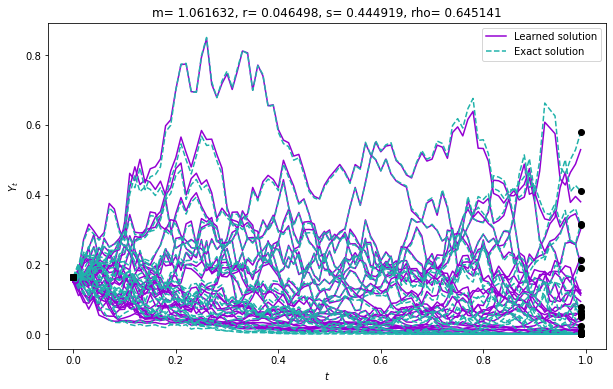

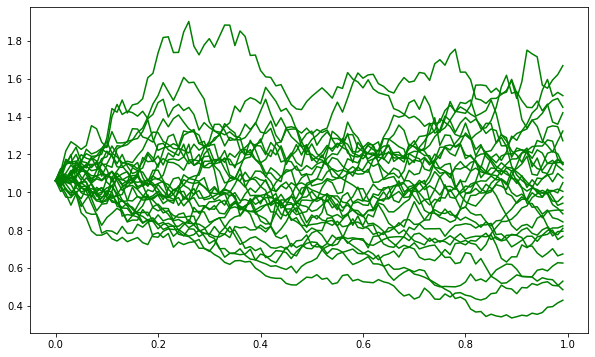

0.09502683 0.05323937


In [21]:
def plot_mc_curves(t_test, y_pred, x_mc, u_hat, y_true=None):
    samples = 29
    plt.figure(figsize=(10, 6))
    plt.plot(t_test[0:1,:].T, y_pred[0:1,:].T,'darkviolet',label='Learned solution')
    plt.plot(t_test[0:1,:].T, y_true[0:1,:].T,'--',color='lightseagreen',label='Exact solution')
    plt.plot(t_test[0:1,-1], y_true[0:1,-1],'ko') #,label='$Y_T = u(T,X_T)$')

    plt.plot(t_test[1:samples,:].T, y_pred[1:samples,:].T,'darkviolet')
    plt.plot(t_test[1:samples,:].T, y_true[1:samples,:].T,'--',color='lightseagreen')
    plt.plot(t_test[1:samples,-1], y_true[1:samples,-1],'ko')

    plt.plot([0],y_true[0,0],'ks') # ,label='$Y_0 = u(0,X_0)$')

    plt.xlabel('$t$')
    plt.ylabel('$Y_t$')
    plt.title(fr'm={u_hat[-1]: 2f}, r={u_hat[0]: 2f}, s={u_hat[1]: 2f}, rho={u_hat[2]: 2f}')# , $\rho$={u_hat[2]: 2f}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(t_test[0:1,:].T, x_mc[0:1,:].T,'g',label='$X_t$')
    plt.plot(t_test[1:samples,:].T, x_mc[1:samples,:].T,'g')
    plt.show()
    
    t = (y_pred[:,0:10] - y_true[:,0:10])/y_true[:,0:10]
    print(np.mean(np.abs(t)), np.std(np.abs(t)))

t_test = np.load('predicted_price/t.npy')
idx_1 = 0
idx = 48
plot_mc_curves(t_test[idx], data[0][idx], data[1][idx], data[3][idx], data[-1][idx])

In [35]:
def evaluate(data):
    y_pred, x_mc, t_test, u, mc_p = data
    if mc_p.ndim == 1:
        t = np.abs(y_pred[:,0,0] - mc_p)
    else:
        t = np.abs(y_pred[:,:,:20] - mc_p[:,:,:20])/0.1
    return [np.mean(t), np.std(t)]

print(evaluate(data)) 


[0.07096048, 0.07285716]


In [35]:
k=103
price_hat = data[0][:k,0,0]
price_true = data[-1][:k]

print(np.mean(np.abs(price_hat - price_true)))

ValueError: operands could not be broadcast together with shapes (60,) (60,1000,100) 